In [1]:
import matplotlib.pyplot as plt
import cv2

image_path = "../dataset_dir/13.한국어글자체/01.손글씨/01_handwriting_sentence_images/1_sentence/00000002.png"

In [2]:
# 이미지 불러오기
image = cv2.imread(image_path)

# 컨투어 찾기 전 이미지 전처리
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
gray = cv2.bitwise_not(gray) # 객체보다 배경이 밝은 경우 이미지 반전

# threshold 등 다양한 전처리 시도 -> 객체와 배경을 가장 잘 분리하는 전처리 사용
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# 윤곽선 찾기 및 박스 추출
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour) 
  boxes.append({
    "x": x,
    "y": y,
    "w": w,
    "h": h,
  })

boxes = sorted(boxes, key=lambda boxes: boxes["x"])

# 결과 이미지 출력
for box in boxes:
  cv2.rectangle(
    image, 
    (box["x"], box["y"]), 
    (box["x"] + box["w"], box["y"] + box["h"]), 
    (0, 255, 0), 
    2)

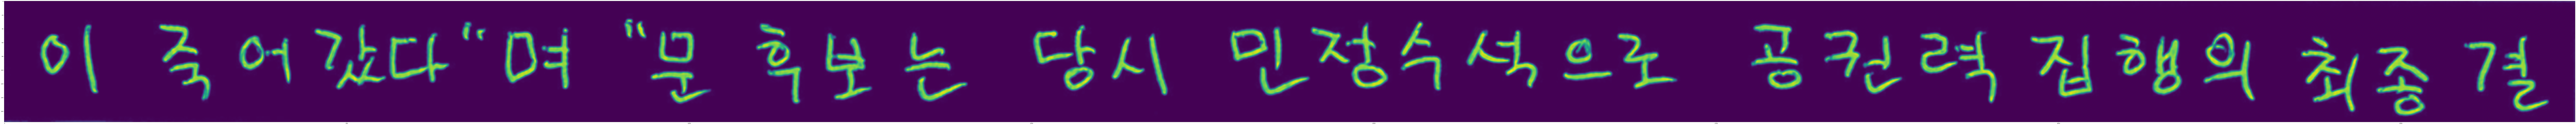

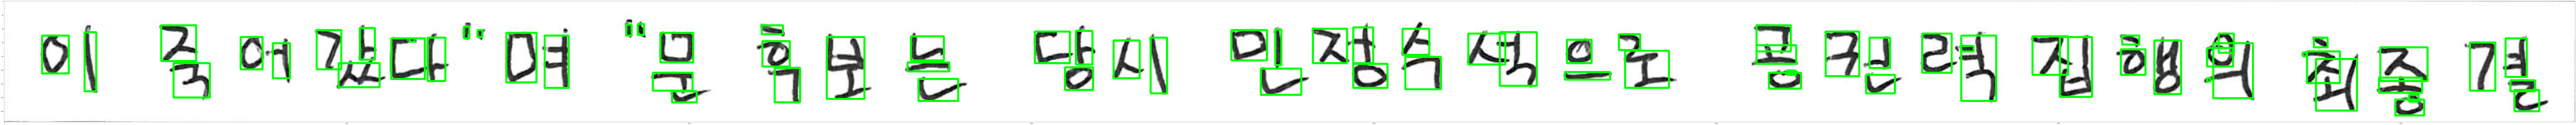

In [3]:
cv2.imwrite("./image/threshold_Filter.png", gray)

plt.figure(figsize=(370, 170))
plt.imshow(gray)
plt.show()

cv2.imwrite("./image/original_recognize_box.png", image)
plt.figure(figsize=(370, 170))
plt.imshow(image)
plt.show()

In [ ]:
import numpy as np

min_distance_value = 38

Primary_group_box_list = []

for rangeNum in range(1, len(boxes)):
    box1 = boxes[rangeNum-1]
    box2 = boxes[rangeNum]

    coordinate_box1 = (
        box1["x"], # X 좌표
        box1["y"], # Y 좌표
        box1["x"] + box1["w"], # W 좌표
        box1["y"] + box1["h"] # H 좌표
    )
    
    coordinate_box2 = (
        box2["x"], # X 좌표
        box2["y"], # Y 좌표
        box2["x"] + box2["w"], # W 좌표
        box2["y"] + box2["h"] # H 좌표
    )


    box1_center_x = (box1["x"] + box1["w"]) / 2
    box1_center_y = (box1["y"] + box1["h"]) / 2


    box2_center_x = (box2["x"] + box2["w"]) / 2
    box2_center_y = (box2["y"] + box2["h"]) / 2

    # 두 박스의 중심점 간의 거리를 계산합니다.
    distance = np.sqrt(
        ((box1_center_x - box2_center_x)**2) +
        ((box1_center_y - box2_center_y)**2)
    )

    """
    b1_x < b2_x + b2_w and
    b2_x < b1_x + b1_w and
    b1_y < b2_y + b2_h and
    b2_y < b1_y + b1_h
    """

    if distance < min_distance_value:
        setGrouping = {
            "x": min(coordinate_box1[0], coordinate_box2[0]), # X 좌표
            "y": min(coordinate_box1[1], coordinate_box2[1]), # Y 좌표
            "w": max(coordinate_box1[2], coordinate_box2[2]), # W 좌표
            "h": max(coordinate_box1[3], coordinate_box2[3]), # H 좌표
            "Euclidean_distance": distance,
        }
        
        Primary_group_box_list.append(setGrouping)

In [5]:
Secondary_group_box_list = [] # 2차 데이터 정규화

for rangeNum in range(1, len(boxes)):
    box1 = boxes[rangeNum-1]
    box2 = boxes[rangeNum]
    
    coordinate_box1 = (
        box1["x"], # X 좌표
        box1["y"], # Y 좌표
        box1["x"] + box1["w"], # W 좌표
        box1["y"] + box1["h"] # H 좌표
    )
    
    coordinate_box2 = (
        box2["x"], # X 좌표
        box2["y"], # Y 좌표
        box2["x"] + box2["w"], # W 좌표
        box2["y"] + box2["h"] # H 좌표
    )


    # box = (x1, y1, x2, y2)
    box1_area = (coordinate_box1[2] - coordinate_box1[0] + 1) * (coordinate_box1[3] - coordinate_box1[1] + 1)
    box2_area = (coordinate_box2[2] - coordinate_box2[0] + 1) * (coordinate_box2[3] - coordinate_box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(coordinate_box1[0], coordinate_box2[0])
    y1 = max(coordinate_box1[1], coordinate_box2[1])
    x2 = min(coordinate_box1[2], coordinate_box2[2])
    y2 = min(coordinate_box1[3], coordinate_box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    
    print(box1, box2, iou, iou > 0)

    """
    # 면적 계산
    area1 = coordinate_box1[2] * coordinate_box1[3]
    area2 = coordinate_box2[2] * coordinate_box2[3]

    # 중첩 영역 계산
    inter_x = max(coordinate_box1[0], coordinate_box2[0])
    inter_y = max(coordinate_box1[1], coordinate_box2[1])
    inter_w = min(coordinate_box1[0] + coordinate_box1[2], coordinate_box2[0] + coordinate_box2[2]) - inter_x
    inter_h = min(coordinate_box1[1] + coordinate_box1[3], coordinate_box2[1] + coordinate_box2[3]) - inter_y
    inter_area = inter_w * inter_h

    # IoU 계산
    iou = inter_area / (area1 + area2 - inter_area)
    """

    if iou > 0:
        setGrouping = {
            "x": min(coordinate_box1[0], coordinate_box2[0]), # X 좌표
            "y": min(coordinate_box1[1], coordinate_box2[1]), # Y 좌표
            "w": max(coordinate_box1[2], coordinate_box2[2]), # W 좌표
            "h": max(coordinate_box1[3], coordinate_box2[3]), # H 좌표
            "iou": iou,
        }
        
        Secondary_group_box_list.append(setGrouping)

{'x': 55, 'y': 50, 'w': 39, 'h': 55} {'x': 117, 'y': 45, 'w': 17, 'h': 86} 0.0 False
{'x': 117, 'y': 45, 'w': 17, 'h': 86} {'x': 229, 'y': 35, 'w': 51, 'h': 52} 0.0 False
{'x': 229, 'y': 35, 'w': 51, 'h': 52} {'x': 247, 'y': 90, 'w': 53, 'h': 50} 0.0 False
{'x': 247, 'y': 90, 'w': 53, 'h': 50} {'x': 345, 'y': 52, 'w': 32, 'h': 47} 0.0 False
{'x': 345, 'y': 52, 'w': 32, 'h': 47} {'x': 392, 'y': 61, 'w': 25, 'h': 51} 0.0 False
{'x': 392, 'y': 61, 'w': 25, 'h': 51} {'x': 456, 'y': 42, 'w': 36, 'h': 57} 0.0 False
{'x': 456, 'y': 42, 'w': 36, 'h': 57} {'x': 488, 'y': 90, 'w': 60, 'h': 35} 0.011649580615097856 True
{'x': 488, 'y': 90, 'w': 60, 'h': 35} {'x': 519, 'y': 39, 'w': 22, 'h': 46} 0.0 False
{'x': 519, 'y': 39, 'w': 22, 'h': 46} {'x': 565, 'y': 54, 'w': 49, 'h': 59} 0.0 False
{'x': 565, 'y': 54, 'w': 49, 'h': 59} {'x': 592, 'y': 54, 'w': 7, 'h': 5} 0.016 True
{'x': 592, 'y': 54, 'w': 7, 'h': 5} {'x': 618, 'y': 53, 'w': 26, 'h': 63} 0.0 False
{'x': 618, 'y': 53, 'w': 26, 'h': 63} {'x'

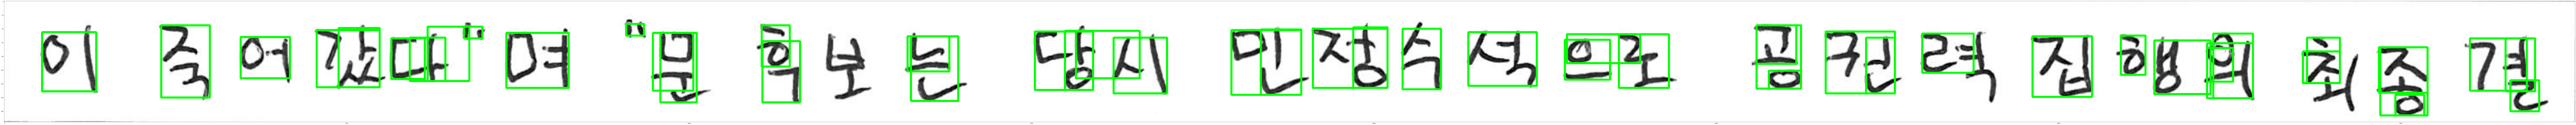

In [6]:
wrtie_image = cv2.imread(image_path)

# 결과 이미지 출력
for box in Primary_group_box_list:
  cv2.rectangle(
    wrtie_image, 
    (box["x"], box["y"]), 
    (box["w"], box["h"]), 
    (0, 255, 0), 
    2)
  
cv2.imwrite("./image/Euclidean_distance_Filter.png", wrtie_image)
  
plt.figure(figsize=(370, 170))
plt.imshow(wrtie_image)
plt.show()

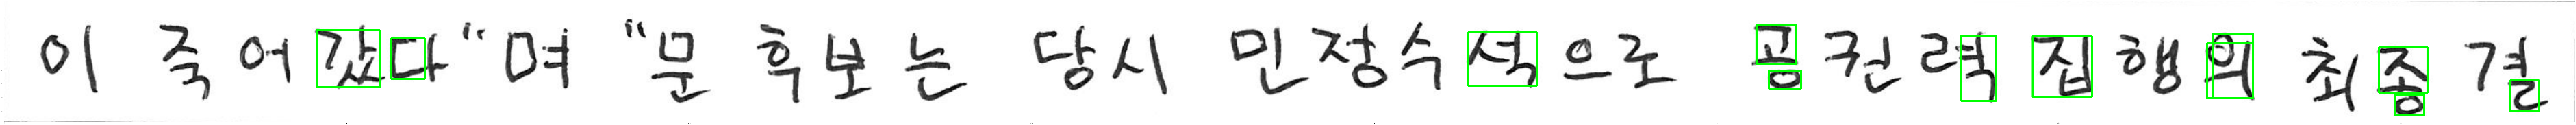

In [7]:
wrtie_image = cv2.imread(image_path)

# 결과 이미지 출력
for box in Secondary_group_box_list:
  cv2.rectangle(
    wrtie_image, 
    (box["x"], box["y"]), 
    (box["w"], box["h"]), 
    (0, 255, 0), 
    2)
  
cv2.imwrite("./image/IoU_Filter.png", wrtie_image)

plt.figure(figsize=(370, 170))
plt.imshow(wrtie_image)
plt.show()

In [8]:
import pandas as pd

group_box_dataframe = pd.DataFrame().from_dict(Primary_group_box_list)
group_box_dataframe
group_box_dataframe["Euclidean_distance"]

/tmp/ipykernel_4191/244753627.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


0     23.853721
1     28.324018
2     21.029741
3     30.870698
4     20.303941
5     28.022313
6     36.311155
7     35.598455
8      9.552487
9     23.837995
10     9.013878
11    20.506097
12    29.107559
13    24.026028
14    27.060118
15     8.944272
16    31.312937
17    25.869867
18    18.506756
19    35.920050
20    22.825424
21    35.355339
22    25.932605
23    34.557922
24    20.838666
25    26.405492
26    27.735356
27    18.062392
28    36.749150
29    34.601301
30     9.848858
31    28.022313
32    10.770330
33    28.848743
34    18.828170
35    22.276669
36    23.711811
37    22.455512
38    23.307724
39    19.830532
40    27.189152
41    35.846897
42    31.312937
43    27.513633
44     9.394147
45    25.124689
46    10.770330
47    25.079872
48    12.093387
49    14.807093
Name: Euclidean_distance, dtype: float64

In [9]:
import pandas as pd

pd.DataFrame().from_dict(Secondary_group_box_list)

,x,y,w,h,iou
0,456,42,548,125,0.011650
1,565,54,614,113,0.016000
2,2138,45,2238,123,0.064077
3,2559,35,2617,91,0.162887
4,2577,101,2624,127,0.046901
5,2858,50,2909,145,0.034255
6,2962,51,3049,139,0.111708
7,3217,61,3284,141,0.166965
8,3226,47,3284,141,0.067634
9,3468,67,3539,133,0.080870


In [10]:
# import cv2

# image = cv2.imread(image_path) # 이미지 자르기

# for box in Primary_group_box_list:
#     output = image[
#         box["y"]-12 : box["h"]+12,
#         box["x"]-12 : box["w"]+12, 
#     ]

#     plt.imshow(output)
#     plt.show()

In [11]:
# import cv2

# image = cv2.imread(image_path) # 이미지 자르기

# for box in Secondary_group_box_list:
#     output = image[
#         box["y"]-12 : box["h"]+12,
#         box["x"]-12 : box["w"]+12, 
#     ]

#     plt.imshow(output)
#     plt.show()